<a href="https://colab.research.google.com/github/hussain0048/Natural-language-processing/blob/main/Natural_Language_Processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Libraries**

This Portion is intended to test all the dependencies that are needed for the rest of the notebooks to run properly. If everything is tested correctly you should see a "You are all set" message when running the code below

In [ ]:
import os
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import ngrams
import string
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from pprint import pprint
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score, precision_score, recall_score
from nltk.corpus import reuters
from operator import itemgetter

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Test that verifies that the imports don't fail and that we have the correct files from nltk downloaded

stopwords.words('english')
word_tokenize('This is just a test')

print('You are all set')

You are all set


# **1- Text Classification**

## **1.1-Binary text classification**

We will address the binary problem of detecting Sport related documents vs any other type of documents. In order to do this we will create an artificial (and very small collection).

Define a set of labelled documents that will be our training dataset. These are the documents the classifier will learn from in order to categorise future unseen documents

Define a set of labelled documents that will be our testing dataset. These will be the "unseen" documents that the classifier will predict (without having being trained with them)

Represent our training and testing documents

Train the classifier based on the training data

Predict the labels for the testing documents

###**1.1.1-Support Vector Machine (SVM)**

#### **Import library**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC

In [ ]:
# Train and test data. Both the full documents and their labels ("Sports" vs "Non Sports")
train_data = ['Football: a great sport', 'The referee has been very bad this season', 'Our team scored 5 goals', 'I love tennis',
              'Politics is in decline in the UK', 'Brexit means Brexit', 'The parlament wants to create new legislation',
              'I so want to travel the world']
train_labels = ["Sports","Sports","Sports","Sports", "Non Sports", "Non Sports", "Non Sports", "Non Sports"]

test_data = ['Swimming is a great sport',
             'A lot of policy changes will happen after Brexit',
             'The table tennis team will travel to the UK soon for the European Championship']
test_labels = ["Sports","Non Sports","Sports"]

#### **Data Preprocessing and model training**

In [ ]:
# Representation of the data using TF-IDF
vectorizer = TfidfVectorizer()
vectorised_train_data = vectorizer.fit_transform(train_data)
vectorised_test_data = vectorizer.transform(test_data)

# Train the classifier given the training data
classifier = LinearSVC()
classifier.fit(vectorised_train_data, train_labels)

# Predict the labels for the test documents (not used for training)
print(classifier.predict(vectorised_test_data))

['Sports' 'Non Sports' 'Non Sports']


However, the third case is wrongly classified. Why do you think that might be?

Matching problems (e.g., "car" is different than "Cars")

Cases never seen before (e.g., the classifier has never seen the word "table")

"Spurious" correlations and bias ("car" appears only in the positive category)

Lets look into how we are representing our documents



In [ ]:
from pprint import pprint

# Function to show the feature weights of a document (to be explained later)
def feature_values(doc, representer):
    doc_representation = representer.transform([doc])
    features = representer.get_feature_names()
    return [(features[index], doc_representation[0, index]) for index in doc_representation.nonzero()[1]]

pprint([feature_values(doc, vectorizer) for doc in test_data])

**Lets try again, with stop-word removal this time**

In [ ]:
from nltk.corpus import stopwords

# Load the list of (english) stop-words from nltk
stop_words = stopwords.words("english")

# Represent, train, predict
vectorizer = TfidfVectorizer(stop_words=stop_words)
vectorised_train_data = vectorizer.fit_transform(train_data)
vectorised_test_data = vectorizer.transform(test_data)
classifier = LinearSVC()
classifier.fit(vectorised_train_data, train_labels)
binary_predictions=classifier.predict(vectorised_test_data)

print(classifier.predict(vectorised_test_data))
# Expected: [Sports, Non Sports, Sports]

['Sports' 'Non Sports' 'Sports']


#### **Model Evaluation**

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score

# Binary problem
binary_labels = [1, 0, 1]
binary_predictions = [1, 0, 0]

# Quality values (with respect to class 1 by default)
# Show our quality
precision = precision_score(binary_labels, binary_predictions)
recall = recall_score(binary_labels, binary_predictions)
f1 = f1_score(binary_labels, binary_predictions)
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision,
                                                                     recall,
                                                                     f1))

binary_labels = ["A", "B", "A"]
binary_predictions = ["A", "B", "B"]
precision = precision_score(binary_labels, binary_predictions, pos_label="A")
recall = recall_score(binary_labels, binary_predictions, pos_label="A")
f1 = f1_score(binary_labels, binary_predictions, pos_label="A")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision,
                                                                     recall,
                                                                     f1))

Micro-average quality numbers
Precision: 1.0000, Recall: 0.5000, F1-measure: 0.6667
Precision: 1.0000, Recall: 0.5000, F1-measure: 0.6667


## **1.2-Multi-Class classification problem**

### **1.2.1-Detecting the Language of senence**



#### **1.2.1-Support Vector Machine (SVM)**

We will address the multi-class problem of detecting the language of a sentence based on 3 mutually exclusive languages (e.g., Spanish, English and French). For the sake of this example, we assume those are the only 3 languages that the documents can have. As before, we will create an artificial (and very small collection) with similar steps

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC

In [ ]:
# Artificial (and small) dataset. Spanish,English,French texts
train_data = ['PyCon es una gran conferencia', 'Aprendizaje automatico esta listo para dominar el mundo dentro de poco',
             'This is a great conference with a lot of amazing talks', 'AI will dominate the world in the near future',
             'Dix chiffres por resumer le feuilleton de la loi travail']
train_labels = ["SP", "SP", "EN", "EN", "FR"]

test_data = ['Estoy preparandome para dominar las olimpiadas', 'Me gustaria mucho aprender el lenguage de programacion Scala',
             'Machine Learning is amazing','Hola a todos']
test_labels = ["SP", "SP", "EN", "SP"]

In [ ]:
# Represent
vectorizer = TfidfVectorizer() # Note, we are not doing stop-word removal. Stop words could be beneficial in this problems
vectorised_train_data = vectorizer.fit_transform(train_data)
vectorised_test_data = vectorizer.transform(test_data)


In [ ]:
# Train
classifier = LinearSVC()
classifier.fit(vectorised_train_data, train_labels)

LinearSVC()

In [ ]:
from pprint import pprint

In [ ]:
# Predict
predictions = classifier.predict(vectorised_test_data)
pprint(predictions)

array(['SP', 'SP', 'EN', 'EN'], dtype='<U2')


The last case is wrong. Can you guess why?

Can we learn from never seen cases?


We will address the multi-label problem of labeling documents as being relevant to Sports or Politics. As before, we will create an artificial (and very small collection) with initial similar steps.

There are two modifications for our example to run in a multi-label way:

- Change the representation of the data viewing every document as a list of bits, representing being or not to each category. (MultiLabelBinarizer)

- Run the classifier N times, once for each category where the negative cases will be the documents in all the other categories. (OneVsRestClassifier)

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier

In [ ]:
# Artificial (and small) dataset. Sports and Politics
train_data = ['Football: a great sport', 'The referee has been very bad this season', 'Our team scored 5 goals', 'I love tennis',
              'Politics is in decline in the UK', 'Brexit means Brexit', 'The parlament wants to create new legislation',
              'I so want to travel the world',
              'The goverment will increase the budget for sports in the UK after the victories in the Olimpic Games',
              "O'Reilly has a great conference this year"]
train_labels = [["Sports"], ["Sports"], ["Sports"], ["Sports"],["Politics"],["Politics"],["Politics"],[],["Politics", "Sports"],[]]

test_data = ['Swimming is a great sport',
             'A lot of policy changes will happen after Brexit',
             'The table tennis team will travel to the UK soon for the European Championship',
             'The goverment will increase the budget for sports in the UK after the victories in the Olimpic Games',
             'PyCon is my favourite conference']
test_labels = [["Sports"], ["Politics"], ["Sports"], ["Politics","Sports"],[]]

In [ ]:
# Change the representation of our data as a list of bit lists
mlb = MultiLabelBinarizer()
binary_train_labels = mlb.fit_transform(train_labels)
binary_test_labels = mlb.transform(test_labels)

print(binary_train_labels)

[[0 0 0 1 0 1]
 [0 0 0 1 0 1]
 [1 0 1 0 0 0]
 [1 0 1 0 0 0]
 [0 1 0 0 1 0]]


In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
from nltk.corpus import stopwords

# Load the list of (english) stop-words from nltk
stop_words = stopwords.words("english")

In [ ]:
# Represent
vectorizer = TfidfVectorizer(stop_words=stop_words)
vectorised_train_data = vectorizer.fit_transform(train_data)
vectorised_test_data = vectorizer.transform(test_data)


In [ ]:
# One classifer built per category using a one vs the rest approach
classifier = OneVsRestClassifier(LinearSVC())
classifier.fit(vectorised_train_data, binary_train_labels)

OneVsRestClassifier(estimator=LinearSVC())

In [ ]:
#Predict
predictions = classifier.predict(vectorised_test_data)

In [ ]:
print(predictions)
print()

[[0 1]
 [1 0]
 [0 1]
 [1 1]
 [0 0]]



In [ ]:
print(mlb.inverse_transform(predictions))


#### **1.2.2-Naive Bayes classifie**

In [ ]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

In [ ]:
# Load the 20 Newsgroups dataset
newsgroups_train = fetch_20newsgroups(subset='train')
newsgroups_test = fetch_20newsgroups(subset='test')

In [ ]:
newsgroups_test

In [ ]:
# Transform the texts into TF-IDF vectors
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(newsgroups_train.data)
X_test = vectorizer.transform(newsgroups_test.data)
y_train = newsgroups_train.target
y_test = newsgroups_test.target

In [ ]:
# Train a Multinomial Naive Bayes classifier
clf = MultinomialNB()
clf.fit(X_train, y_train)

In [ ]:
# Predict the newsgroup of the test texts
y_pred = clf.predict(X_test)

In [ ]:
# Evaluate the classifier's accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 77.39%


This code will load the 20 Newsgroups dataset and split it into training and test sets. Then it will transform the texts into numerical representation using TfidfVectorizer and train a Multinomial Naive Bayes classifier using the training set. Finally, it will use the trained classifier to predict the newsgroup of the test texts and evaluate the classifier’s accuracy.

#### **1.2.3-Logistic Regression**

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [ ]:
from sklearn.linear_model import LogisticRegression as LR

In [ ]:
lr_clf = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf',LR())])

In [ ]:
%%time
lr_clf.fit(X=train_data, y=train_labels) # note that .fit function calls are inplace, and the Pipeline is not re-assigned

CPU times: user 24.5 ms, sys: 99 µs, total: 24.6 ms
Wall time: 61 ms


Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression())])

In [ ]:
lr_predicted = lr_clf.predict(test_data)

In [ ]:
lr_acc = sum(lr_predicted == test_labels)/len(lr_predicted)

In [ ]:
lr_acc

0.75

In [ ]:
def imdb_acc(pipeline_clf):
    predictions = pipeline_clf.predict(test_data)
    assert len(test_labels) == len(predictions)
    return sum(predictions == test_labels)/len(test_labels), predictions

**Remove Stop Words**

In [ ]:
lr_clf = Pipeline([('vect', CountVectorizer(stop_words='english')), ('tfidf', TfidfTransformer()), ('clf',LR())])
lr_clf.fit(X=train_data, y=train_labels)
lr_acc, lr_predictions = imdb_acc(lr_clf)
lr_acc

0.75

**Increase the Ngram Range**

In [ ]:
lr_clf = Pipeline([('vect', CountVectorizer(stop_words='english', ngram_range=(1,3))), ('tfidf', TfidfTransformer()), ('clf',LR())])
lr_clf.fit(X=train_data, y=train_labels)
lr_acc, lr_predictions = imdb_acc(lr_clf)
lr_acc

1.0

#### **1.2.4- Tree Baseed Models**

**Decision Trees**

In [ ]:
from sklearn.tree import DecisionTreeClassifier as DTC
dtc_clf = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf',DTC())])
dtc_clf.fit(X=train_data, y=train_labels)
dtc_acc, dtc_predictions = imdb_acc(dtc_clf)
dtc_acc

0.75

**Random Forest Classifier**

In [ ]:
from sklearn.ensemble import RandomForestClassifier as RFC
rfc_clf = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf',RFC())])
rfc_clf.fit(X=train_data, y=train_labels)
rfc_acc, rfc_predictions = imdb_acc(rfc_clf)
rfc_acc

0.75

**Extra Trees Classifier**

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier as XTC
xtc_clf = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf',XTC())])
xtc_clf.fit(X=train_data, y=train_labels)
xtc_acc, xtc_predictions = imdb_acc(xtc_clf)
xtc_acc

1.0

#### **1.2.5-Automatically Fine Tuning**

**RandomizedSearch**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
param_grid = dict(clf__C=[50, 75, 85, 100],
                  vect__stop_words=['english', None],
                  vect__ngram_range = [(1, 1), (1, 3)],
                  vect__lowercase = [True, False],
                 )

In [ ]:
random_search = RandomizedSearchCV(lr_clf, param_distributions=param_grid, n_iter=5, scoring='accuracy', n_jobs=-1, cv=3)

In [ ]:
random_search.fit(train_data, train_labels)

### **1.2.2--Sentiment Analysis**


#### **1.2.3-Text Pre-processing**

**Tokenization**


In [ ]:
text = 'Wisdoms daughter walks alone. The mark of Athena burns through rome'

words = text.split()
print(words)



['Wisdoms', 'daughter', 'walks', 'alone.', 'The', 'mark', 'of', 'Athena', 'burns', 'through', 'rome']


**Normalisation**


In [ ]:
text = "'To Sleep Or NOT to SLEep, THAT is THe Question'"

def lower_case(text):
    text = text.lower()
    return text

lower_case = lower_case(text)#converts everthing to lowercase
print(lower_case)

'to sleep or not to sleep, that is the question'


In [ ]:
from nltk.corpus import stopwords

# Load the list of (english) stop-words from nltk
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# Initialize sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Define text to be analyzed
text = "I love this product, it's amazing"

# Get sentiment score
sentiment_score = sia.polarity_scores(text)

# Print sentiment score
print(sentiment_score)

# Classify sentiment as positive, negative, or neutral
if sentiment_score['compound'] > 0.5:
    print("Positive sentiment")
elif sentiment_score['compound'] < -0.5:
    print("Negative sentiment")
else:
    print("Neutral sentiment")

{'neg': 0.0, 'neu': 0.273, 'pos': 0.727, 'compound': 0.8402}
Positive sentiment


**TF-IDF and Term Frequency in Text Analysis**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Sample documents
documents = [
    "The cat chased the mouse.",
    "The mouse ran away."
]

# Create the TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Generate the TF-IDF matrix
tfidf_matrix = vectorizer.fit_transform(documents)

# Get the feature names (terms)
terms = vectorizer.get_feature_names_out()

# Print the TF-IDF scores for each term in each document
for i, doc in enumerate(documents):
    print(f"Document {i+1}:")
    for j, term in enumerate(terms):
        tfidf_score = tfidf_matrix[i, j]
        if tfidf_score > 0:
            print(f"    {term}: {tfidf_score:.3f}")

Document 1:
    cat: 0.470
    chased: 0.470
    mouse: 0.334
    the: 0.669
Document 2:
    away: 0.576
    mouse: 0.410
    ran: 0.576
    the: 0.410


#### **1.2.4-Movie Reviews using Bayes theorem**

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re # for regex
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.metrics import accuracy_score
import pickle

**Dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Courses /Data Science /NLP/Datasets/IMDB-Dataset.csv')
print(data.shape)
data.head()

(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
data.info()

In [ ]:
data.sentiment.value_counts()

In [ ]:
data.sentiment.replace('positive',1,inplace=True)
data.sentiment.replace('negative',0,inplace=True)
data.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1
5,"Probably my all-time favorite movie, a story o...",1
6,I sure would like to see a resurrection of a u...,1
7,"This show was an amazing, fresh & innovative i...",0
8,Encouraged by the positive comments about this...,0
9,If you like original gut wrenching laughter yo...,1


In [ ]:
data.review[0]

**Pre-processing Steps**

- Remove HTML tags
- Remove special characters
- Convert everything to lowercase
- Remove stopwords
- Stemming

1. **Remove HTML tags**

In [ ]:
def clean(text):
    cleaned = re.compile(r'<.*?>')
    return re.sub(cleaned,'',text)


In [ ]:
data.review = data.review.apply(clean)
data.review[0]

**2. Remove special characters**

In [ ]:
def is_special(text):
    rem = ''
    for i in text:
        if i.isalnum():
            rem = rem + i
        else:
            rem = rem + ' '
    return rem

In [ ]:
data.review = data.review.apply(is_special)
data.review[0]

**3. Convert everything to lowercase**


In [ ]:
def to_lower(text):
    return text.lower()

In [ ]:
data.review = data.review.apply(to_lower)
data.review[0]

**4. Remove stopwords**

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
def rem_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    return [w for w in words if w not in stop_words]

In [ ]:
data.review = data.review.apply(rem_stopwords)
data.review[0]

**5-Stem the words**

In [ ]:
def stem_txt(text):
    ss = SnowballStemmer('english')
    return " ".join([ss.stem(w) for w in text])

In [ ]:
data.review = data.review.apply(stem_txt)
data.review[0]

'one review mention watch 1 oz episod hook right exact happen first thing struck oz brutal unflinch scene violenc set right word go trust show faint heart timid show pull punch regard drug sex violenc hardcor classic use word call oz nicknam given oswald maximum secur state penitentari focus main emerald citi experiment section prison cell glass front face inward privaci high agenda em citi home mani aryan muslim gangsta latino christian italian irish scuffl death stare dodgi deal shadi agreement never far away would say main appeal show due fact goe show dare forget pretti pictur paint mainstream audienc forget charm forget romanc oz mess around first episod ever saw struck nasti surreal say readi watch develop tast oz got accustom high level graphic violenc violenc injustic crook guard sold nickel inmat kill order get away well manner middl class inmat turn prison bitch due lack street skill prison experi watch oz may becom comfort uncomfort view that get touch darker side'

In [ ]:
data.head()

**CREATING THE MODEL**


**1. Creating Bag Of Words (BOW)**


In [ ]:
X = np.array(data.iloc[:,0].values)
y = np.array(data.sentiment.values)
cv = CountVectorizer(max_features = 1000)
X = cv.fit_transform(data.review).toarray()
print("X.shape = ",X.shape)
print("y.shape = ",y.shape)

X.shape =  (50000, 1000)
y.shape =  (50000,)


**2. Train test split**

In [ ]:
trainx,testx,trainy,testy = train_test_split(X,y,test_size=0.2,random_state=9)
print("Train shapes : X = {}, y = {}".format(trainx.shape,trainy.shape))
print("Test shapes : X = {}, y = {}".format(testx.shape,testy.shape))

Train shapes : X = (40000, 1000), y = (40000,)
Test shapes : X = (10000, 1000), y = (10000,)


**3. Defining the models and Training them**


In [ ]:
gnb,mnb,bnb = GaussianNB(),MultinomialNB(alpha=1.0,fit_prior=True),BernoulliNB(alpha=1.0,fit_prior=True)
gnb.fit(trainx,trainy)
mnb.fit(trainx,trainy)
bnb.fit(trainx,trainy)

BernoulliNB()

**4. Prediction and accuracy metrics to choose best model**


In [ ]:
ypg = gnb.predict(testx)
ypm = mnb.predict(testx)
ypb = bnb.predict(testx)

print("Gaussian = ",accuracy_score(testy,ypg))
print("Multinomial = ",accuracy_score(testy,ypm))
print("Bernoulli = ",accuracy_score(testy,ypb))

Gaussian =  0.7843
Multinomial =  0.831
Bernoulli =  0.8386


In [ ]:
pickle.dump(bnb,open('model1.pkl','wb'))

In [ ]:
rev =  """Terrible. Complete trash. Brainless tripe. Insulting to anyone who isn't an 8 year old fan boy. Im actually pretty disgusted that this movie is making the money it is - what does it say about the people who brainlessly hand over the hard earned cash to be 'entertained' in this fashion and then come here to leave a positive 8.8 review?? Oh yes, they are morons. Its the only sensible conclusion to draw. How anyone can rate this movie amongst the pantheon of great titles is beyond me.

So trying to find something constructive to say about this title is hard...I enjoyed Iron Man? Tony Stark is an inspirational character in his own movies but here he is a pale shadow of that...About the only 'hook' this movie had into me was wondering when and if Iron Man would knock Captain America out...Oh how I wished he had :( What were these other characters anyways? Useless, bickering idiots who really couldn't organise happy times in a brewery. The film was a chaotic mish mash of action elements and failed 'set pieces'...

I found the villain to be quite amusing.

And now I give up. This movie is not robbing any more of my time but I felt I ought to contribute to restoring the obvious fake rating and reviews this movie has been getting on IMDb."""


In [ ]:
f1 = clean(rev)
f2 = is_special(f1)
f3 = to_lower(f2)
f4 = rem_stopwords(f3)
f5 = stem_txt(f4)

In [ ]:
bow,words = [],word_tokenize(f5)
for word in words:
    bow.append(words.count(word))
#np.array(bow).reshape(1,3000)
#bow.shape
word_dict = cv.vocabulary_
pickle.dump(word_dict,open('bow.pkl','wb'))

In [ ]:
inp = []
for i in word_dict:
    inp.append(f5.count(i[0]))
y_pred = bnb.predict(np.array(inp).reshape(1,1000))

In [ ]:
print(y_pred)

[0]


#### **1.2.5-Spam Detection**

##### **1.2.5.1-Naive_bayes**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB


In [ ]:
data = pd.read_csv("https://raw.githubusercontent.com/amankharwal/SMS-Spam-Detection/master/spam.csv", encoding= 'latin-1')
data.head()

,class,message,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
data = data[["class", "message"]]


In [ ]:
x = np.array(data["message"])
y = np.array(data["class"])

In order to use textual data for predictive modeling, the text must be parsed to remove certain words – this process is called tokenization. These words need to then be encoded as integers, or floating-point values, for use as inputs in machine learning algorithms. This process is called feature extraction (or vectorization).

Scikit-learn’s CountVectorizer is used to convert a collection of text documents to a vector of term/token counts. It also enables the ​pre-processing of text data prior to generating the vector representation. This functionality makes it a highly flexible feature representation module for text.

In [ ]:
cv = CountVectorizer()
X = cv.fit_transform(x) # Fit the Data (# Encode the Document)

In [ ]:
print(x)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


In [ ]:
clf = MultinomialNB()
clf.fit(X_train,y_train)

MultinomialNB()

In [ ]:
sample = input('Enter a message:')
data = cv.transform([sample]).toarray()
print(clf.predict(data))

Enter a message:i am your friend
['ham']


##### **1.2.5-2 Support Vector Machine**

**Detect emails whether spam or ham using Support Vector Machine and**

###### I**mport Relevant Libraries**



In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split , GridSearchCV , KFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score , classification_report , confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from nltk.stem import PorterStemmer
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer

###### **Import dataset from GitHub**



In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/Sanjay-dev-ds/spam_ham_email_detector/master/spam.csv")
df.head()

,Label,EmailText
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


###### **Data-Preprocessing**


**Remove duplicate values**



In [ ]:
df = df.drop_duplicates(keep='first')


**Split into Independent and dependent variable**



In [ ]:
x = df['EmailText'].values
y = df['Label'].values

###### **Text Pre-Processing**


creating a function to lowercase the text, remove special characters, normalize certain words, use stems of words instead of the original form using porter stemmer algorithm.

In [ ]:
porter_stemmer=PorterStemmer()
def preprocessor(text):

    text=text.lower()
    text=re.sub("\\W"," ",text)
    text=re.sub("\\s+(in|the|all|for|and|on)\\s+"," _connector_ ",text)
    words=re.split("\\s+",text)
    stemmed_words=[porter_stemmer.stem(word=word) for word in words]
    return ' '.join(stemmed_words)

creating tokenizer function to

Create a space between special characters

Split based on whitespace

In [ ]:
def tokenizer(text):
    text=re.sub("(\\W)"," \\1 ",text)
    return re.split("\\s+",text)

Count Vectorizer is used to transform a corpus of text to a vector of term.

min_df = 0.06 ( taking 0.6% of Minimum Document Frequency )

ngram_range=(1,2) ( word level Unigrams and bigrams)

In [ ]:
vectorizer = CountVectorizer(tokenizer=tokenizer,ngram_range=(1,2),min_df=0.006,preprocessor=preprocessor)
x  = vectorizer.fit_transform(x)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


###### **Check Data is imbalanced**


In [ ]:
sns.countplot(df['Label'])


ValueError: ignored

target class has an uneven distribution of observations, So we are using random over sampling method to balance the target variable’s observation

Random Oversampling: randomly duplicate examples in the minority class (Spam)

In [ ]:
from imblearn.under_sampling import NearMiss
from collections import Counter
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)

print('Original dataset shape', Counter(y))

# fit predictor and target
x,y = ros.fit_resample(x, y)

print('Modified dataset shape', Counter(y))

Original dataset shape Counter({'ham': 4516, 'spam': 653})
Modified dataset shape Counter({'ham': 4516, 'spam': 4516})


###### **Split into training and testing set**



In [ ]:
x_train , x_test , y_train , y_test   = train_test_split(x, y, test_size =0.2,random_state = 0)

###### **Build SVM Model**


In [ ]:
model   = SVC(C =1,kernel = "linear" )
model.fit(x_train,y_train)

SVC(C=1, kernel='linear')

**Check accuracy score**



In [ ]:
accuracy = metrics.accuracy_score(y_test, model.predict(x_test))
accuracy_percentage = 100 * accuracy
accuracy_percentage

98.83785279468734

###### **Hyperparameter Optimization using Grid Search CV**


In [ ]:
params  = {"C":[0.2,0.5] , "kernel" : ['linear', 'sigmoid'] }


In [ ]:
cval = KFold(n_splits = 2)
model =  SVC();
TunedModel = GridSearchCV(model,params,cv= cval)
TunedModel.fit(x_train,y_train)

GridSearchCV(cv=KFold(n_splits=2, random_state=None, shuffle=False),
             estimator=SVC(),
             param_grid={'C': [0.2, 0.5], 'kernel': ['linear', 'sigmoid']})

Accuracy of tuned model



In [ ]:
accuracy = metrics.accuracy_score(y_test, TunedModel.predict(x_test))
accuracy_percentage = 100 * accuracy
accuracy_percentage

99.0038738240177

###### **Model Evaluation**

Confusion Matrix



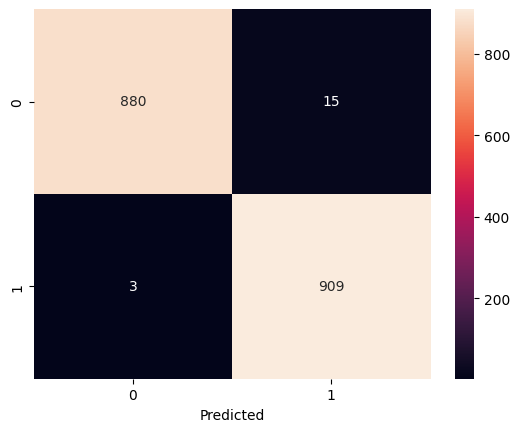

In [ ]:
sns.heatmap(confusion_matrix(y_test,TunedModel.predict(x_test)),annot = True , fmt ="g")
plt.xlabel("Predicted")
plt.show("Actual")
plt.show()

**classification report**

In [ ]:
print(classification_report(y_test,TunedModel.predict(x_test)))


              precision    recall  f1-score   support

         ham       1.00      0.98      0.99       895
        spam       0.98      1.00      0.99       912

    accuracy                           0.99      1807
   macro avg       0.99      0.99      0.99      1807
weighted avg       0.99      0.99      0.99      1807



Using the trained model, predict whether the following five emails are spam or ham

In [ ]:
mails = ["Hey, you have won a car !!!!. Conrgratzz"
              ,"Dear applicant, Your CV has been recieved. Best regards"
              ,"You have received $1000000 to your account"
              ,"Join with our whatsapp group"
              ,"Kindly check the previous email. Kind Regard"]
for mail in mails:
  is_spam = TunedModel.predict(vectorizer.transform([mail]).toarray())
  print(mail + " : "+ is_spam)

['Hey, you have won a car !!!!. Conrgratzz : spam']
['Dear applicant, Your CV has been recieved. Best regards : ham']
['You have received $1000000 to your account : spam']
['Join with our whatsapp group : ham']
['Kindly check the previous email. Kind Regard : ham']


### **1.2.6 -Emotion Detection [10]**

**Choosing Your Dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#%%
import pandas as pd
import numpy as np
data = pd.read_csv('/content/drive/MyDrive/Courses /Data Science /NLP/Datasets/Emotion /text_emotion.csv')

**Understanding What’s Inside Your Dataset**

In [ ]:
data.head()

,tweet_id,sentiment,author,content
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...


This one’s a simple dataset with just four columns, the tweet ID, emotion depicted by the tweet, the author, and the text content of the tweet.
We do not necessarily need the author column. Hence we can drop it.

In [ ]:
data = data.drop('author', axis=1)


In [ ]:
data.head()

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...


The dataset has 40,000 tweets in total, labeled into 13 different human sentiments. Our task here is to build a model, such that give a new tweet or text sentence, it can accurately identify which of the emotions (for which it is trained to recognize) it depicts.
For this tutorial let us consider just two of these sentiments for simplicity, ‘happiness’ and ‘sadness’ (which constitute a total of about 10,000 tweets from the entire sample of data). We can thus drop rows with all other labels.

In [ ]:
# Dropping rows with other emotion labels
data = data.drop(data[data.sentiment == 'anger'].index)
data = data.drop(data[data.sentiment == 'boredom'].index)
data = data.drop(data[data.sentiment == 'enthusiasm'].index)
data = data.drop(data[data.sentiment == 'empty'].index)
data = data.drop(data[data.sentiment == 'fun'].index)
data = data.drop(data[data.sentiment == 'relief'].index)
data = data.drop(data[data.sentiment == 'surprise'].index)
data = data.drop(data[data.sentiment == 'love'].index)
data = data.drop(data[data.sentiment == 'hate'].index)
data = data.drop(data[data.sentiment == 'neutral'].index)
data = data.drop(data[data.sentiment == 'worry'].index)

In [ ]:
data.head()

,tweet_id,sentiment,content
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
6,1956968487,sadness,"I should be sleep, but im not! thinking about ..."
8,1956969035,sadness,@charviray Charlene my love. I miss you
9,1956969172,sadness,@kelcouch I'm sorry at least it's Friday?


**Preprocessing the Data**

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
#Making all letters lowercase
data['content'] = data['content'].apply(lambda x: " ".join(x.lower() for x in x.split()))
#Removing Punctuation, Symbols
data['content'] = data['content'].str.replace('[^\w\s]',' ')
#Removing Stop Words using NLTK
from nltk.corpus import stopwords
stop = stopwords.words('english')
data['content'] = data['content'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

<ipython-input-10-1c8527e3e95d>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  data['content'] = data['content'].str.replace('[^\w\s]',' ')


In [ ]:

  import nltk
  nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
#Lemmatisation
from textblob import Word
data['content'] = data['content'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
#Correcting Letter Repetitions
import re
def de_repeat(text):
    pattern = re.compile(r"(.)\1{2,}")
    return pattern.sub(r"\1\1", text)
#%%
data['content'] = data['content'].apply(lambda x: " ".join(de_repeat(x) for x in x.split()))

Next consideration is the idea that if a word is appearing only once in the entire sample of data, then it most likely has no influence in determining the sentiment of the text. Hence we can remove all the rarely occurring words from the dataset which are generally proper nouns and other insignificant words with respect to the current context.

In [ ]:
# Code to find the top 10,000 rarest words appearing in the data
freq = pd.Series(' '.join(data['content']).split()).value_counts()[-10000:]
# Removing all those rarely appearing words from the data
freq = list(freq.index)
data['content'] = data['content'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))

 **Feature Extraction**

Once you make the text data clean, precise, and error-free, each tweet is represented by a group of keywords. Now, we need to perform ‘Feature Extraction’, i.e extracting some parameters from the data that can be presented numerically. In this article, we consider two different features, TF-IDF & Count Vectors (Remember, we need numeric data for the math!).
Split the data into training and testing parts before performing feature extraction.

In [ ]:
#Encoding output labels 'sadness' as '1' & 'happiness' as '0'
from sklearn import preprocessing
lbl_enc = preprocessing.LabelEncoder()
y = lbl_enc.fit_transform(data.sentiment.values)
# Splitting into training and testing data in 90:10 ratio
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(data.content.values, y, stratify=y, random_state=42, test_size=0.1, shuffle=True)

**Term Frequency-Inverse Document Frequency (TF-IDF):** This parameter gives the relative importance of a term in the data and is a measure of how frequently and rarely it appears in the text. This can be directly extracted in python as follows-

In [ ]:
# Extracting TF-IDF parameters
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=1000, analyzer='word',ngram_range=(1,3))
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.fit_transform(X_val)

**Count Vectors:** This is another feature we consider and as the name suggests we transform our tweet into an array having the count of appearances of each word in it. The intuition here is that the text that conveys similar emotions may have the same words repeated over and over again. This is more like the direct approach.

In [ ]:
# Extracting Count Vectors Parameters
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(analyzer='word')
count_vect.fit(data['content'])
X_train_count =  count_vect.transform(X_train)
X_val_count =  count_vect.transform(X_val)

**Training Our Models**

**First, let us build some models using the TF-IDF features-**

**1-Multinomial Naive Bayes Classifier**

In [ ]:
from sklearn.metrics import accuracy_score
# Model 1: Multinomial Naive Bayes Classifier
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)
y_pred = nb.predict(X_val_tfidf)
print('naive bayes tfidf accuracy %s' % accuracy_score(y_pred, y_val))

naive bayes tfidf accuracy 0.48265895953757226


**Model 2: Linear SVM**

In [ ]:
from sklearn.linear_model import SGDClassifier
lsvm = SGDClassifier(alpha=0.001, random_state=5, max_iter=15, tol=None)
lsvm.fit(X_train_tfidf, y_train)
y_pred = lsvm.predict(X_val_tfidf)
print('svm using tfidf accuracy %s' % accuracy_score(y_pred, y_val))


svm using tfidf accuracy 0.5096339113680154


**Model 3: logistic regression**

In [ ]:
# Model 3: logistic regression
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1)
logreg.fit(X_train_tfidf, y_train)
y_pred = logreg.predict(X_val_tfidf)
print('log reg tfidf accuracy %s' % accuracy_score(y_pred, y_val))

log reg tfidf accuracy 0.4951830443159923


**Model 4: Random Forest Classifier**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=500)
rf.fit(X_train_tfidf, y_train)
y_pred = rf.predict(X_val_tfidf)
print('random forest tfidf accuracy %s' % accuracy_score(y_pred, y_val))

random forest tfidf accuracy 0.5057803468208093


**Now, let’s build models using count vectors features-**

In [ ]:
# Model 1: Multinomial Naive Bayes Classifier
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train_count, y_train)
y_pred = nb.predict(X_val_count)
print('naive bayes count vectors accuracy %s' % accuracy_score(y_pred, y_val))

naive bayes count vectors accuracy 0.7745664739884393


In [ ]:
# Model 2: Linear SVM
from sklearn.linear_model import SGDClassifier
lsvm = SGDClassifier(alpha=0.001, random_state=5, max_iter=15, tol=None)
lsvm.fit(X_train_count, y_train)
y_pred = lsvm.predict(X_val_count)
print('lsvm using count vectors accuracy %s' % accuracy_score(y_pred, y_val))

lsvm using count vectors accuracy 0.7832369942196532


In [ ]:
# Model 3: Logistic Regression
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1)
logreg.fit(X_train_count, y_train)
y_pred = logreg.predict(X_val_count)
print('log reg count vectors accuracy %s' % accuracy_score(y_pred, y_val))

log reg count vectors accuracy 0.7832369942196532


In [ ]:
# Model 4: Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=500)
rf.fit(X_train_count, y_train)
y_pred = rf.predict(X_val_count)
print('random forest with count vectors accuracy %s' % accuracy_score(y_pred, y_val))

random forest with count vectors accuracy 0.7466281310211946


By using count vectors, we have a significant improvement in performance. The best model, linear SVM achieved up to 79.28% accuracy.

This might be because of the nature of this specific dataset where the emotion of the text is heavily dependent on the presence of some significant adjectives.

Let us now test how it performs in reality by giving this model some random text input.

In [ ]:
#Below are 8 random statements.
#The first 4 depict happiness
#The last 4 depict sadness
tweets = pd.DataFrame(['I am very happy today! The atmosphere looks cheerful',
'Things are looking great. It was such a good day',
'Success is right around the corner. Lets celebrate this victory',
'Everything is more beautiful when you experience them with a smile!',
'Now this is my worst, okay? But I am gonna get better.',
'I am tired, boss. Tired of being on the road, lonely as a sparrow in the rain. I am tired of all the pain I feel',
'This is quite depressing. I am filled with sorrow',
'His death broke my heart. It was a sad day'])
# Doing some preprocessing on these tweets as done before
tweets[0] = tweets[0].str.replace('[^\w\s]',' ')
from nltk.corpus import stopwords
stop = stopwords.words('english')
tweets[0] = tweets[0].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
from textblob import Word
tweets[0] = tweets[0].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
# Extracting Count Vectors feature from our tweets
tweet_count = count_vect.transform(tweets[0])
#Predicting the emotion of the tweet using our already trained linear SVM
tweet_pred = lsvm.predict(tweet_count)
print(tweet_pred)


[0 0 0 0 1 1 1 1]


<ipython-input-29-8f3f43198744>:13: FutureWarning: The default value of regex will change from True to False in a future version.
  tweets[0] = tweets[0].str.replace('[^\w\s]',' ')


# **2-Machine Translation**

# **3- Named Entity Recognition (NER)**


In [ ]:
import spacy

# Load the pre-trained model
nlp = spacy.load("en_core_web_sm")

# Define text to be analyzed
text = "Barack Obama visited the White House today"

# Process the text with the model
doc = nlp(text)

# Extract named entities
for ent in doc.ents:
    print(ent.text, ent.label_)

Barack Obama PERSON
the White House ORG


# **4-Text Summarization**


# **5- Information Extraction**

# **6-Text Generation**


In [ ]:
!pip install -U sentence-transformers


In [ ]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import numpy as np


# Load the GPT-2 model and tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

# Define the prompt and generate text
prompt = "Once upon a time in a land far, far away"
generated_text = model.generate(input_ids=tokenizer.encode(prompt))

# Decode the generated text
generated_text = tokenizer.decode(generated_text)
print(generated_text)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


AttributeError: ignored

# **7-Text Clustering**


# **8- Speech Recognition**


# **9- Text-to-Speech (TTS)**


# **References**

[1-nlp-tutorial](https://github.com/bonzanini/nlp-tutorial/blob/master/notebooks/00%20Environment%20Test.ipynb)

[2-Named Entity Recognition (NER)](https://thecleverprogrammer.com/2020/08/04/named-entity-recognition-ner/)

[3-Modern Methods for Text Classification](https://github.com/NirantK/NLP_Quickbook/blob/master/05_Text_Classification.ipynb)

[4-NLP_Quickbook](https://github.com/NirantK/NLP_Quickbook/tree/master)

[5-The Super Duper NLP Repo](https://notebooks.quantumstat.com/)

[6-01_OnePipeline_ManyClassifiers.ipynb](https://colab.research.google.com/github/practical-nlp/practical-nlp/blob/master/Ch4/01_OnePipeline_ManyClassifiers.ipynb#scrollTo=BYW_S3585xXF)

[7-Two minutes NLP — 21 Learning Resources for Text Classification](https://medium.com/nlplanet/two-minutes-nlp-21-learning-resources-for-text-classification-b6f9c43793e1)

[8-Building a Text Classifier App with Hugging Face, BERT, and Comet](https://heartbeat.comet.ml/building-a-text-classifier-app-with-hugging-face-bert-and-comet-278e4cd0d0aa)

[9-Spam-Ham Email Detection](https://medium.com/@dssc2022yt/spam-ham-email-detection-d548a6d5869e)

[10-Applied Machine Learning: Part 3](https://medium.com/the-research-nest/applied-machine-learning-part-3-3fd405842a18)